In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam

In [2]:
BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, "dataset")

CLASS_NAMES = [
    "High_Motor_Coordination_Risk",
    "Mild_Motor_Coordination_Risk"
]

CLASS_DIRS = {
    class_name: os.path.join(DATASET_DIR, class_name)
    for class_name in CLASS_NAMES
}

print("Dataset path:", DATASET_DIR)
print("Classes found:", CLASS_DIRS)


Dataset path: c:\Projects\Dyspraxia\dataset
Classes found: {'High_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\High_Motor_Coordination_Risk', 'Mild_Motor_Coordination_Risk': 'c:\\Projects\\Dyspraxia\\dataset\\Mild_Motor_Coordination_Risk'}


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode="nearest"
)


train_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 200 images belonging to 2 classes.
Found 49 images belonging to 2 classes.


In [5]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False  # transfer learning


In [6]:

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.4)(x)

output = Dense(2, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [7]:


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,410,661 (16.83 MB)

 Trainable params: 361,090 (1.38 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
EPOCHS = 20

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 17s 738ms/step - accuracy: 0.5650 - loss: 0.6992 - val_accuracy: 0.5510 - val_loss: 0.6879
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 526ms/step - accuracy: 0.4750 - loss: 0.7197 - val_accuracy: 0.5714 - val_loss: 0.6852
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 566ms/step - accuracy: 0.5750 - loss: 0.6911 - val_accuracy: 0.5510 - val_loss: 0.6853
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.4950 - loss: 0.7097 - val_accuracy: 0.5510 - val_loss: 0.6874
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 533ms/step - accuracy: 0.5250 - loss: 0.6956 - val_accuracy: 0.5510 - val_loss: 0.6852
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 552ms/step - accuracy: 0.5400 - loss: 0.7055 - val_accuracy: 0.5510 - val_loss: 0.6854
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 545ms/step - accuracy: 0.4950 - loss: 0.7016 - val_accuracy: 0.5510 - val_loss: 0.6828
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 636ms/step - accuracy: 0.4850 - loss: 0.7060 - val_accuracy: 0

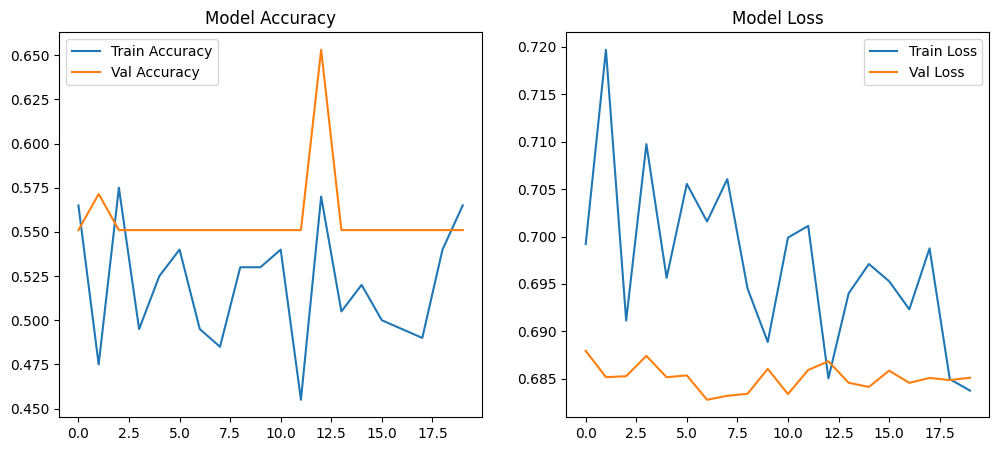

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')

plt.show()


In [10]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Enable fine-tuning
base_model.trainable = True

# Freeze early layers
for layer in base_model.layers[:-40]:
    layer.trainable = False


In [11]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(2, activation="softmax")(x)

model_ft = Model(inputs=base_model.input, outputs=output)

model_ft.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)


In [12]:
history_ft = model_ft.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 29s 977ms/step - accuracy: 0.5000 - loss: 0.7065 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5510 - val_loss: 0.7015 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 647ms/step - accuracy: 0.5000 - loss: 0.7160 - precision: 0.5000 - recall: 0.5000 - val_accuracy: 0.5510 - val_loss: 0.6988 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 695ms/step - accuracy: 0.5300 - loss: 0.6979 - precision: 0.5300 - recall: 0.5300 - val_accuracy: 0.5510 - val_loss: 0.6967 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step - accuracy: 0.5350 - loss: 0.6773 - precision: 0.5350 - recall: 0.5350 - val_accuracy: 0.5510 - val_loss: 0.6955 - val_precision: 0.5510 - val_recall: 0.5510
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 639ms/step - accuracy: 0.6000 - loss: 0.6822 - precision: 0.6000 - recall: 0.6000 - val_accuracy: 0.5510 - val_loss: 0

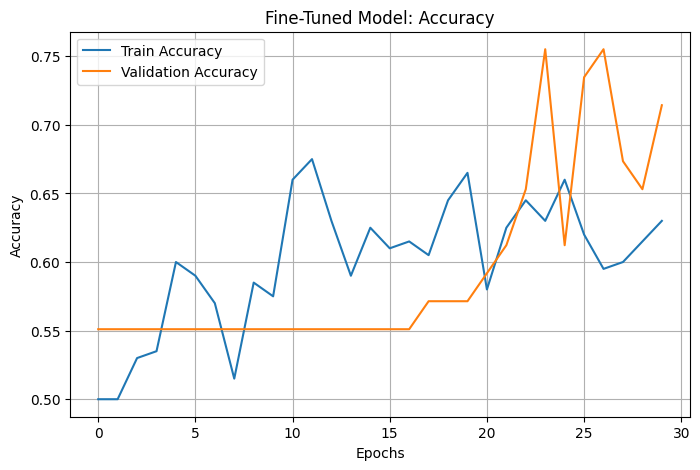

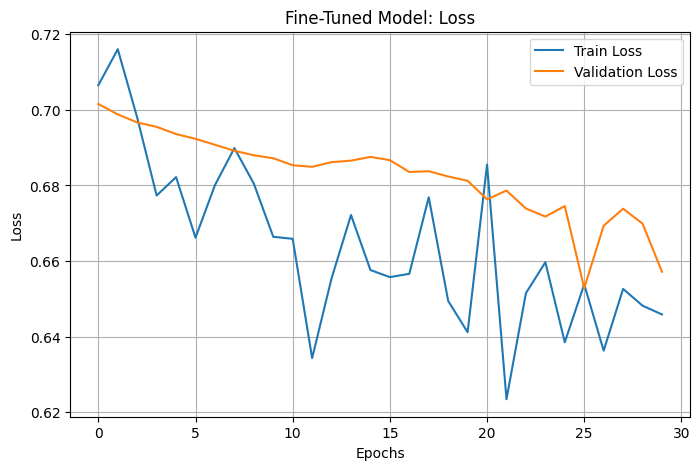

In [13]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.figure(figsize=(8, 5))
plt.plot(history_ft.history["accuracy"], label="Train Accuracy")
plt.plot(history_ft.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Fine-Tuned Model: Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss graph
plt.figure(figsize=(8, 5))
plt.plot(history_ft.history["loss"], label="Train Loss")
plt.plot(history_ft.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Fine-Tuned Model: Loss")
plt.legend()
plt.grid(True)
plt.show()
